# Cluster-GCN for node classification

This notebook demonstrates how to use `StellarGraph`'s implementation of *Cluster-GCN*, [1], for node classification on a homogeneous graph.

*Cluster-GCN* is an extension of the Graph Convolutional Network (GCN) algorithm, [2], for scalable training of deeper Graph Neural Networks using Stochastic Gradient Descent (SGD).

As a first step, *Cluster-GCN* splits a given graph into `k` non-overlapping subgraphs, i.e., no two subgraphs share a node. In [1], it is suggested that for best classification performance, the *METIS* graph clustering algorithm, [3], should be utilised; *METIS* groups together nodes that form a well connected neighborhood with few connections to other subgraphs. The default clustering algorithm `StellarGraph` uses is the random assignment of nodes to clusters. The user is free to use any suitable clustering algorithm to determine the clusters before training the *Cluster-GCN* model. 

This notebook demonstrates how to use either random clustering or METIS. For the latter, it is necessary that 3rd party software has correctly been installed; later, we provide links to websites that host the software and provide detailed installation instructions. 

During model training, each subgraph or combination of subgraphs is treated as a mini-batch for estimating the parameters of a *GCN* model. A pass over all subgraphs is considered a training epoch.

*Cluster-GCN* further extends *GCN* from the transductive to the inductive setting but this is not demonstrated in this notebook.

This notebook demonstrates *Cluster-GCN* for node classification using 2 citation network datasets, `Cora` and `PubMed-Diabetes`.

**References**

[1] Cluster-GCN: An Efficient Algorithm for Training Deep and Large Graph Convolutional Networks. W. Chiang, X. Liu, S. Si, Y. Li, S. Bengio, and C. Hsiej, KDD, 2019, arXiv:1905.07953 ([download link](https://arxiv.org/abs/1905.07953))

[2] Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 ([download link](https://arxiv.org/abs/1609.02907))

[3] METIS: Serial Graph Partitioning and Fill-reducing Matrix Ordering. ([download link](http://glaros.dtc.umn.edu/gkhome/views/metis))

In [1]:
import networkx as nx
import pandas as pd
import itertools
import json
import os

import numpy as np

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import ClusterGCN
from stellargraph import globalvar

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.simplefilter("ignore", SparseEfficiencyWarning)

### Loading the dataset

This notebook demonstrates node classification using the *Cluster-GCN* algorithm using one of two citation networks, `Cora` and `Pubmed`.

In [2]:
display(HTML(datasets.Cora().description))
display(HTML(datasets.PubMedDiabetes().description))

In [3]:
dataset = "pubmed"  # can also select 'pubmed'

if dataset == "cora":
    G, labels = datasets.Cora().load()
elif dataset == "pubmed":
    G, labels = datasets.PubMedDiabetes().load()

In [4]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]


In [5]:
set(labels)

{1, 2, 3}

### Splitting the data

We aim to train a graph-ML model that will predict the **subject** or **label** (depending on the dataset) attribute on the nodes.

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

The number of labeled nodes we use for training depends on the dataset. We use 140 labeled nodes for `Cora` and 60 for `Pubmed` training. The validation and test sets have the same sizes for both datasets. We use 500 nodes for validation and the rest for testing.

In [6]:
if dataset == "cora":
    train_size = 140
elif dataset == "pubmed":
    train_size = 60

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=train_size, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=500, test_size=None, stratify=test_labels
)

Note using stratified sampling gives the following counts:

In [7]:
from collections import Counter

Counter(train_labels)

Counter({1: 12, 3: 24, 2: 24})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

Next, we prepare a Pandas DataFrame holding the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. `Cora` contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. `Pubmed` has similar feature vectors associated with each node but the values are [tf-idf.](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

## Train using cluster GCN

### Graph Clustering 

*Cluster-GCN* requires that a graph is clustered into `k` non-overlapping subgraphs. These subgraphs are used as batches to train a *GCN* model. 

Any graph clustering method can be used, including random clustering that is the default clustering method in `StellarGraph`. 

However, the choice of clustering algorithm can have a large impact on performance. In the *Cluster-GCN* paper, [1], it is suggested that the *METIS* algorithm is used as it produces subgraphs that are well connected with few intra-graph edges. 

This demo uses random clustering by default. 

#### METIS

In order to use *METIS*, you must download and install the official implemention from [here](http://glaros.dtc.umn.edu/gkhome/views/metis). Also, you must install the Python `metis` library by following the instructions [here.](https://metis.readthedocs.io/en/latest/)

In [9]:
number_of_clusters = 10  # the number of clusters/subgraphs
clusters_per_batch = 2  # combine two cluster per batch
random_clusters = True  # Set to False if you want to use METIS for clustering

In [10]:
node_ids = np.array(G.nodes())

In [11]:
if random_clusters:
    # We don't have to specify the cluster because the CluserNodeGenerator will take
    # care of the random clustering for us.
    clusters = number_of_clusters
else:
    import metis

    # We are going to use the METIS clustering algorith,
    print("Graph clustering using the METIS algorithm.")
    edgecuts, parts = metis.part_graph(G, number_of_clusters)
    parts = np.array(parts)
    clusters = []
    cluster_ids = np.unique(parts)
    for cluster_id in cluster_ids:
        mask = np.where(parts == cluster_id)
        clusters.append(node_ids[mask])

Next we create the `ClusterNodeGenerator` object that will give us access to a generator suitable for model training, evaluation, and prediction via the Keras API. 

We specify the number of clusters and the number of clusters to combine per batch, **q**.

In [12]:
generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)

Number of clusters 10
0 cluster has size 1971
1 cluster has size 1971
2 cluster has size 1971
3 cluster has size 1971
4 cluster has size 1971
5 cluster has size 1971
6 cluster has size 1971
7 cluster has size 1971
8 cluster has size 1971
9 cluster has size 1978


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 32-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 

We create the *Cluster-GCN* model as follows:

In [13]:
cluster_gcn = ClusterGCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the *Cluster-GCN* model for node prediction, via the `ClusterGCN.build` method:

In [14]:
x_inp, x_out = cluster_gcn.build()

In [15]:
x_inp

[<tf.Tensor 'input_1:0' shape=(1, None, 500) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(1, None, None) dtype=int32>,
 <tf.Tensor 'input_3:0' shape=(1, None, None) dtype=float32>]

In [16]:
x_out

<tf.Tensor 'cluster_graph_convolution_1/Identity:0' shape=(None, None, 32) dtype=float32>

We are also going to add a final layer dense layer with softmax output activation. This layers performs classification so we set the number of units to equal the number of classes.

In [17]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [18]:
predictions

<tf.Tensor 'dense/Identity:0' shape=(None, None, 3) dtype=float32>

Finally, we build the Tensorflow model and compile it specifying the loss function, optimiser, and metrics to monitor.

In [19]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

### Train the model

We are now ready to train the `ClusterGCN` model, keeping track of its loss and accuracy on the training set, and its generalisation performance on a validation set.

We need two generators, one for training and one for validation data. We can create such generators by calling the `flow` method of the `ClusterNodeGenerator` object we created earlier and specifying the node IDs and corresponding ground truth target values for each of the two datasets. 

In [20]:
train_gen = generator.flow(train_labels.index, train_targets, name="train")
val_gen = generator.flow(val_labels.index, val_targets, name="val")

Finally, we are ready to train our `ClusterGCN` model by calling the `fit_generator` method of our Tensorflow Keras model.

In [21]:
history = model.fit_generator(
    train_gen, validation_data=val_gen, epochs=20, verbose=1, shuffle=False
)

Epoch 1/20
5/5 [==============================] - 3s 569ms/step - loss: 1.1006 - acc: 0.3333 - val_loss: 1.0758 - val_acc: 0.3920
Epoch 2/20
5/5 [==============================] - 2s 421ms/step - loss: 1.0737 - acc: 0.3833 - val_loss: 1.0603 - val_acc: 0.4300
Epoch 3/20
5/5 [==============================] - 2s 441ms/step - loss: 1.0359 - acc: 0.5333 - val_loss: 1.0357 - val_acc: 0.5940
Epoch 4/20
5/5 [==============================] - 2s 473ms/step - loss: 0.9957 - acc: 0.5667 - val_loss: 1.0121 - val_acc: 0.5180
Epoch 5/20
5/5 [==============================] - 2s 425ms/step - loss: 0.9635 - acc: 0.5333 - val_loss: 0.9905 - val_acc: 0.5960
Epoch 6/20
5/5 [==============================] - 2s 416ms/step - loss: 0.8977 - acc: 0.6833 - val_loss: 0.9577 - val_acc: 0.6040
Epoch 7/20
5/5 [==============================] - 2s 415ms/step - loss: 0.8696 - acc: 0.6833 - val_loss: 0.8913 - val_acc: 0.5840
Epoch 8/20
5/5 [==============================] - 2s 415ms/step - loss: 0.8085 - acc: 0.63

Plot the training history:

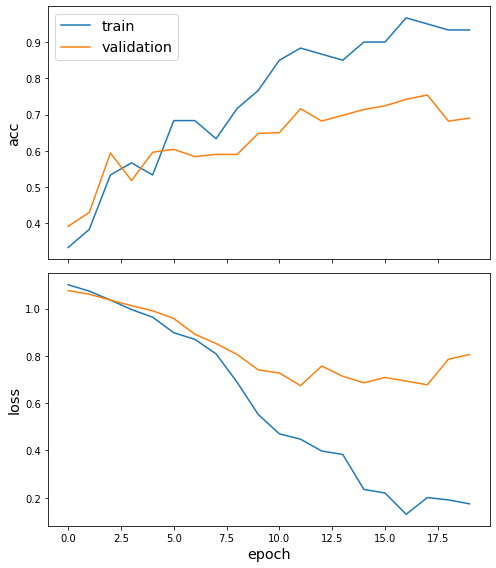

In [22]:
sg.utils.plot_history(history)

Evaluate the best model on the test set.

Note that *Cluster-GCN* performance can be very poor if using random graph clustering. Using *METIS* instead of random graph clustering produces considerably better results.

In [23]:
test_gen = generator.flow(test_labels.index, test_targets)

In [24]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7875
	acc: 0.6994


### Making predictions with the model

For predictions to work correctly, we need to remove the extra batch dimensions necessary for the implementation of *Cluster-GCN* to work. We can easily achieve this by adding a layer after the dense predictions layer to remove this extra dimension.

In [25]:
predictions_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(predictions)

In [26]:
# Notice that we have removed the first dimension
predictions, predictions_flat

(<tf.Tensor 'dense/Identity:0' shape=(None, None, 3) dtype=float32>,
 <tf.Tensor 'lambda_1/Identity:0' shape=(None, 3) dtype=float32>)

Now let's get the predictions for all nodes.

We need to create a new model using the same as before input Tensor and our new **predictions_flat** Tensor as the output. We are going to re-use the trained model weights.

In [27]:
model_predict = Model(inputs=x_inp, outputs=predictions_flat)

In [28]:
all_nodes = list(G.nodes())
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict_generator(all_gen)

In [29]:
all_predictions.shape

(19717, 3)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

In [30]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few predictions after training the model:

In [31]:
len(all_gen.node_order)

19717

In [32]:
results = pd.Series(node_predictions, index=all_gen.node_order)
df = pd.DataFrame({"Predicted": results, "True": labels})
df.head(10)

,Predicted,True
7145,1,1
29094,1,1
34420,3,1
34548,1,1
37920,1,1
47533,2,2
48487,2,2
49051,1,1
65509,2,2
65672,2,2


## Node embeddings

Evaluate node embeddings as activations of the output of the last graph convolution layer in the `ClusterGCN` layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

Note that the embeddings from the `ClusterGCN` model have a batch dimension of 1 so we `squeeze` this to get a matrix of $N_{nodes} \times N_{emb}$.

In [33]:
x_out_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
embedding_model = Model(inputs=x_inp, outputs=x_out_flat)

In [34]:
emb = embedding_model.predict_generator(all_gen, verbose=1)
emb.shape

5/5 [==============================] - 1s 190ms/step


(19717, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

**Prediction Node Order**

The predictions are not returned in the same order as the input nodes given. The generator object internally maintains the order of predictions. These are stored in the object's member variable `node_order`. We use `node_order` to re-index the `node_data` DataFrame such that the prediction order in `y` corresponds to that of node embeddings in `X`.

In [36]:
X = emb
y = np.argmax(
    target_encoding.transform(labels.reindex(index=all_gen.node_order)), axis=1,
)

In [37]:
if X.shape[1] > 2:
    transform = TSNE  # or use PCA for speed

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=all_gen.node_order)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

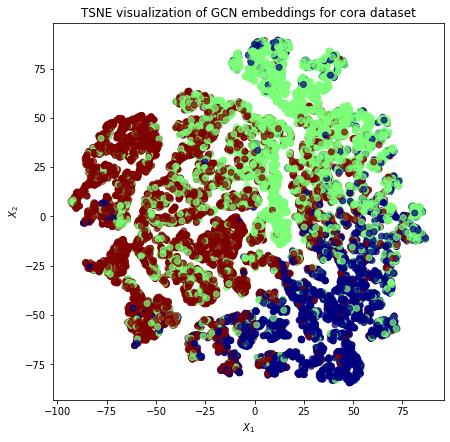

In [38]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GCN embeddings for cora dataset".format(transform.__name__)
)
plt.show()